In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf,adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing,Holt
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
data=pd.read_csv('exchange_rate.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [5]:
data['date'] = pd.to_datetime(data['date'],format='%d-%m-%Y %H:%M')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     7588 non-null   datetime64[ns]
 1   Ex_rate  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.7 KB


In [7]:
fig =go.Figure()
fig.add_trace(go.Scatter(x=data['date'], y=data['Ex_rate'], mode='lines', name='USD to AUD', line=dict(color='blue')))
fig.show()

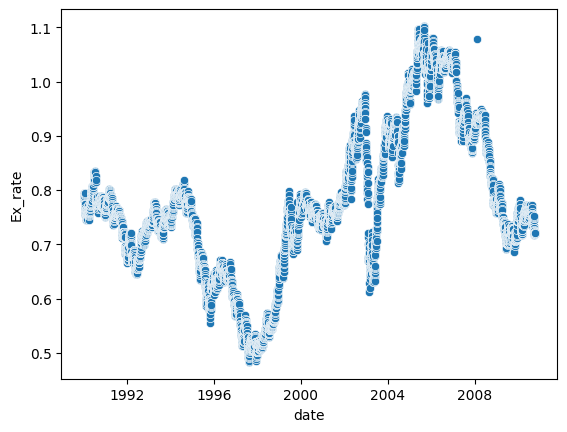

In [8]:
sns.scatterplot(x='date', y='Ex_rate', data=data)
plt.show()

In [10]:
correlation = data['date'].corr(data['Ex_rate'])
correlation

np.float64(0.49520682277737493)

<Axes: >

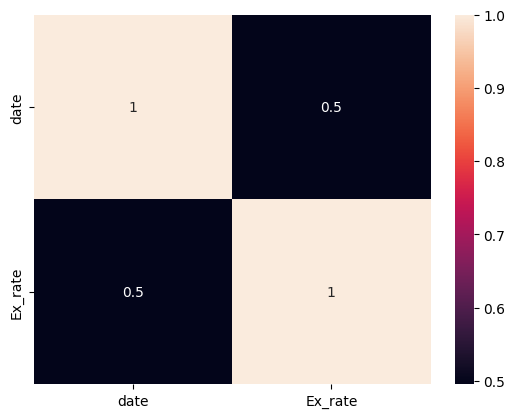

In [11]:
sns.heatmap(data.corr(), annot=True)

In [13]:
result = seasonal_decompose(data['Ex_rate'], model='additive', period=365)  
trace_seasonal = go.Scatter(x=data['date'], y=result.seasonal, mode='lines', name='Seasonal Component', line=dict(color='blue'))
fig = go.Figure(data=[trace_seasonal])
fig.show()

In [16]:
rolling_mean = data['Ex_rate'].rolling(window=30).mean()
rolling_std = data['Ex_rate'].rolling(window=30).std()

threshold = 2

anomaly_indices = data[(data['Ex_rate'] > rolling_mean + threshold * rolling_std) | (data['Ex_rate'] < rolling_mean - threshold * rolling_std)].index
trace_exchange_rate = go.Scatter(x=data['date'], y=data['Ex_rate'], mode='lines', name='Exchange Rate', line=dict(color='blue'))
trace_anomalies = go.Scatter(x=data.loc[anomaly_indices, 'date'], y=data.loc[anomaly_indices, 'Ex_rate'], mode='markers', name='Anomalies', marker=dict(color='red', size=8))

fig = go.Figure()
fig.add_trace(trace_exchange_rate)
fig.add_trace(trace_anomalies)
fig.show()

# Data Preprocessing

In [17]:
from scipy.stats import iqr

In [18]:
Q1 = data['Ex_rate'].quantile(0.25)
Q3 = data['Ex_rate'].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5
anomaly_indices = data[(data['Ex_rate'] < Q1 - threshold * IQR) | (data['Ex_rate'] > Q3 + threshold * IQR)].index

In [19]:
if len(anomaly_indices) == 0:
    print("No anomalies detected.")
else:
    print("Anomalies detected at indices:", anomaly_indices)

No anomalies detected.


In [21]:
lags = 50
acf_values = acf(data['Ex_rate'], nlags=lags)
pacf_values = pacf(data['Ex_rate'], nlags=lags)

In [22]:
acf_trace = go.Scatter(x=np.arange(len(acf_values)), y=acf_values, mode='lines', name='ACF')
pacf_trace = go.Scatter(x=np.arange(len(pacf_values)), y=pacf_values, mode='lines', name='PACF')
fig_acf = go.Figure(data=[acf_trace])

fig_pacf = go.Figure(data=[pacf_trace])

fig_acf.show()
fig_pacf.show()

In [23]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

In [26]:
result = adfuller(data['Ex_rate'])
result

(np.float64(-1.6649941807381414),
 np.float64(0.4492327353597959),
 1,
 7586,
 {'1%': np.float64(-3.4312123140180137),
  '5%': np.float64(-2.861921078147796),
  '10%': np.float64(-2.5669728434336108)},
 np.float64(-55835.06254628545))

In [27]:
data['Ex_rate_diff'] = data['Ex_rate'].diff(1)
data.dropna(inplace=True)
data['Ex_rate_diff']


date
1990-01-02   -0.003700
1990-01-03    0.004900
1990-01-04   -0.000700
1990-01-05   -0.001100
1990-01-06    0.001700
                ...   
2010-10-06   -0.000207
2010-10-07    0.003345
2010-10-08    0.001358
2010-10-09   -0.002372
2010-10-10    0.000000
Name: Ex_rate_diff, Length: 7587, dtype: float64

In [28]:
result_diff = adfuller(data['Ex_rate_diff'])
result_diff

(np.float64(-99.3934312011863),
 0.0,
 0,
 7586,
 {'1%': np.float64(-3.4312123140180137),
  '5%': np.float64(-2.861921078147796),
  '10%': np.float64(-2.5669728434336108)},
 np.float64(-55825.924350489135))

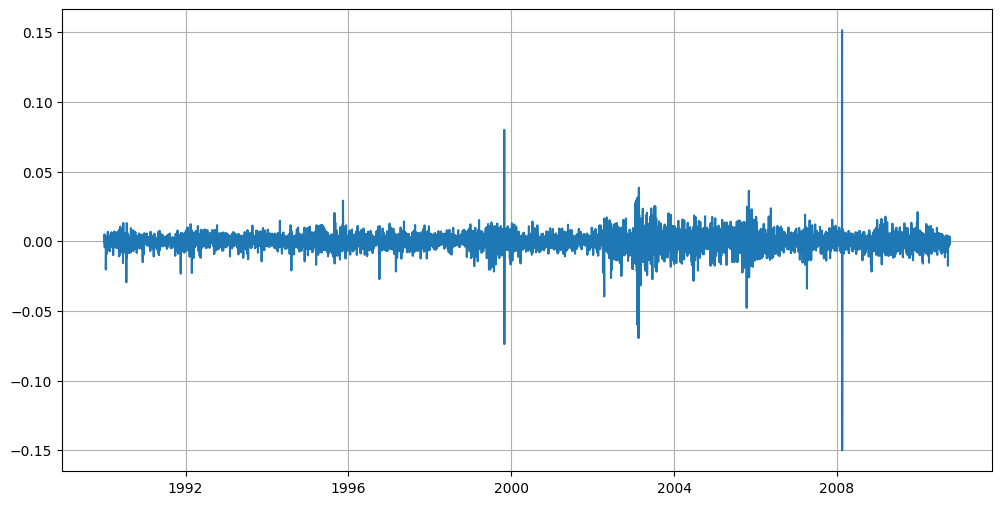

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(data['Ex_rate_diff'])
plt.grid(True)
plt.show()

In [30]:
p=1
d=1
q=0
model = ARIMA(data['Ex_rate'], order=(p, d, q))
results = model.fit()
results.summary()

c:\Users\revan\Sravani Mam\DSA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\revan\Sravani Mam\DSA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\revan\Sravani Mam\DSA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 7587
Model:                 ARIMA(1, 1, 0)   Log Likelihood               28050.092
Date:                Sat, 11 Jan 2025   AIC                         -56096.183
Time:                        23:30:41   BIC                         -56082.315
Sample:                    01-02-1990   HQIC                        -56091.424
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1313      0.002    -64.403      0.000      -0.135      -0.127
sigma2      3.596e-05   9.94e-08    361.674      0.000    3.58e-05    3.62e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2864753.27
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        98.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

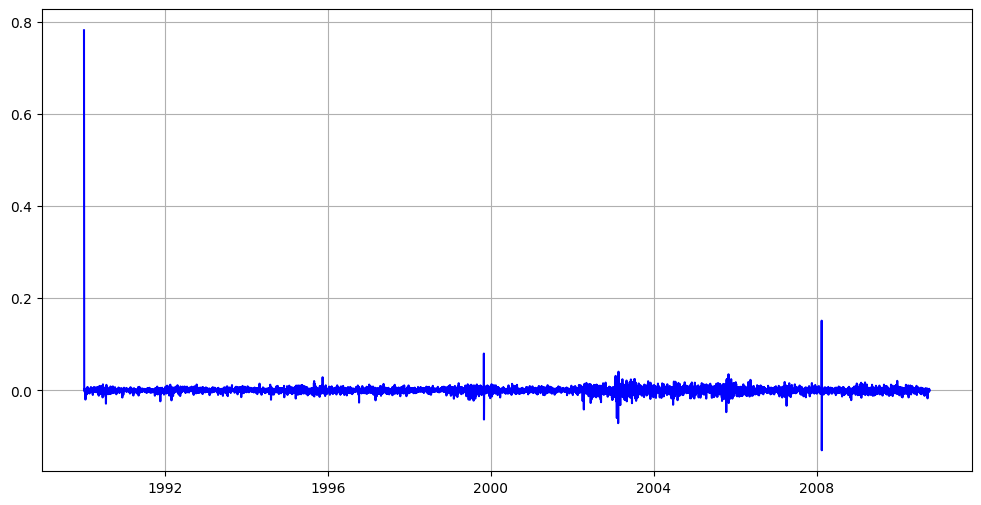

In [32]:
residuals = results.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals, color='blue')
plt.grid(True)
plt.show()

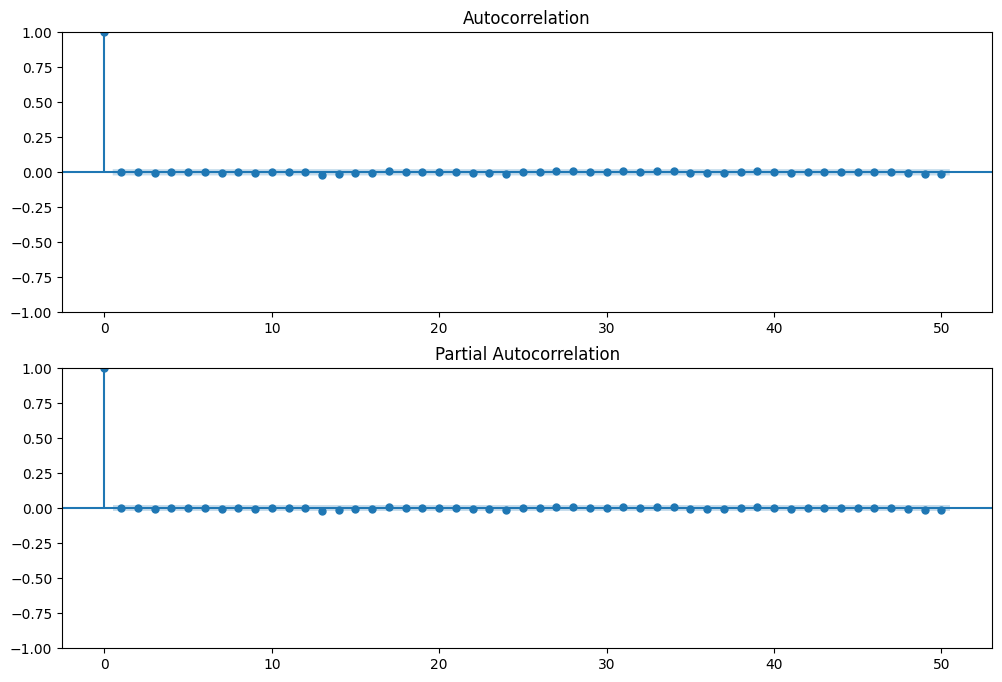

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals, lags=50, ax=ax[0])
plot_pacf(residuals, lags=50, ax=ax[1])
plt.show()

In [34]:
lb_test_stat, lb_test_p_value = acorr_ljungbox(residuals, lags=20)
for lag, stat, p_value in zip(range(1, 21), lb_test_stat, lb_test_p_value):
    print(f'{lag}\t{stat:.2f}\t{p_value:.2f}' if isinstance(stat, float) and isinstance(p_value, float) else f'{lag}\t{stat}\t{p_value}')

1	l	l
2	b	b
3	_	_
4	s	p
5	t	v
6	a	a
7	t	l


In [35]:
jb_test = stats.jarque_bera(residuals)
jb_test

SignificanceResult(statistic=np.float64(4173619579.3151283), pvalue=np.float64(0.0))

In [36]:
order = (1, 1, 1)
train_data = data['Ex_rate'][:-30]

if not isinstance(train_data.index, pd.RangeIndex) or train_data.index[0] != 0:
    train_data = train_data.reset_index(drop=True)

model = ARIMA(train_data, order=order)
results = model.fit()
residuals = results.resid
lb_test_stat, lb_test_p_value = acorr_ljungbox(residuals, lags=20)
for p_val_str in lb_test_p_value:
    if p_val_str != 'l' and p_val_str != 'b':
        break
    order = (order[0] + 1, 1, order[2] + 1)
    model = ARIMA(train_data, order=order)
    results = model.fit()

    residuals = results.resid
    lb_test_stat, lb_test_p_value = acorr_ljungbox(residuals, lags=20)
order

(3, 1, 3)

c:\Users\revan\Sravani Mam\DSA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\revan\Sravani Mam\DSA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\revan\Sravani Mam\DSA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



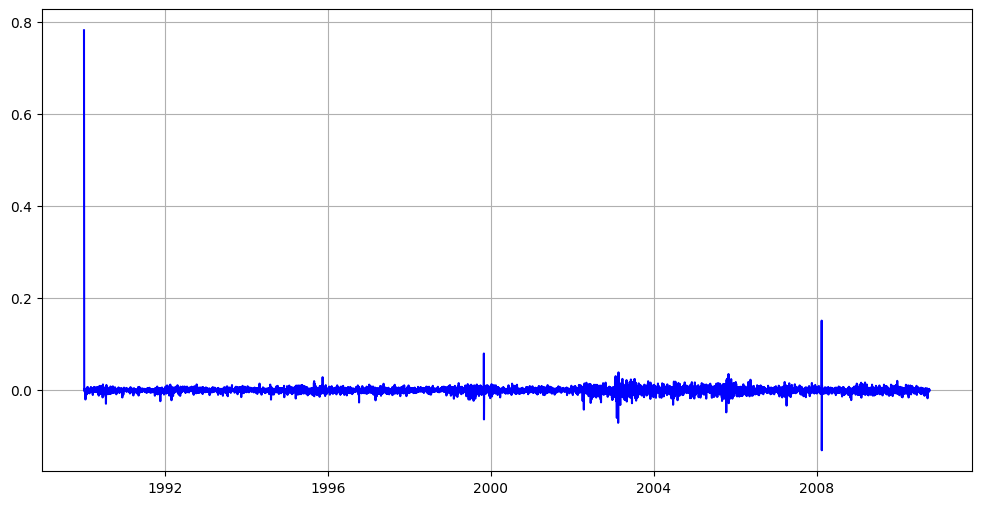

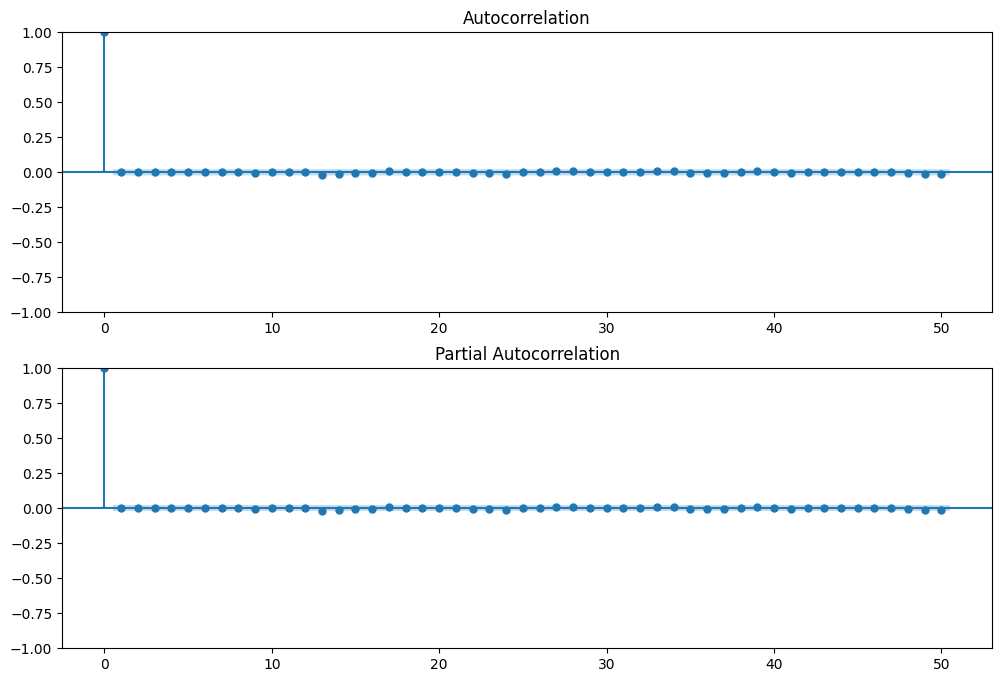

1	l	l
2	b	b
3	_	_
4	s	p
5	t	v
6	a	a
7	t	l


SignificanceResult(statistic=np.float64(4171374053.0753026), pvalue=np.float64(0.0))

In [37]:
model = ARIMA(data['Ex_rate'], order=(3, 1, 3))
results = model.fit()
residuals = results.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals, color='blue')
plt.grid(True)
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals, lags=50, ax=ax[0])
plot_pacf(residuals, lags=50, ax=ax[1])
plt.show()

lb_test_stat, lb_test_p_value = acorr_ljungbox(residuals, lags=20)
for lag, stat, p_value in zip(range(1, 21), lb_test_stat, lb_test_p_value):
    if isinstance(stat, (int, float)) and isinstance(p_value, (int, float)):
        print(f'{lag}\t{stat:.2f}\t{p_value:.2f}')
    else:
        print(f'{lag}\t{stat}\t{p_value}')

jb_test = stats.jarque_bera(residuals)
jb_test

In [38]:
forecast_dates = pd.date_range(start=data.index[-1], periods=30, freq='D') 
forecast_values = results.predict(start=len(data), end=len(data) + 29)  
trace_actual = go.Scatter(x=data.index, y=data['Ex_rate'], mode='lines', name='Actual', line=dict(color='blue'))
trace_forecast = go.Scatter(x=forecast_dates, y=forecast_values, mode='lines', name='Forecast', line=dict(color='red'))

fig = go.Figure([trace_actual, trace_forecast])

fig.show()

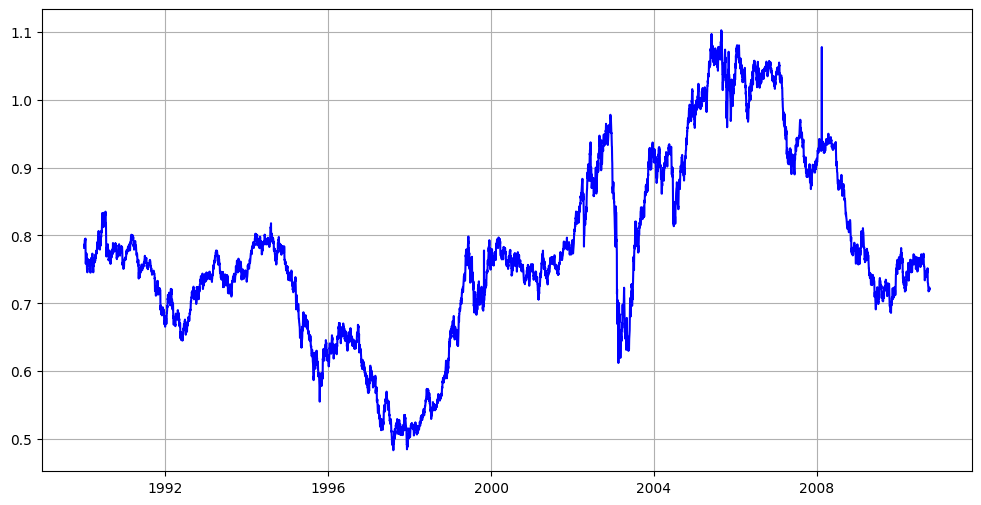

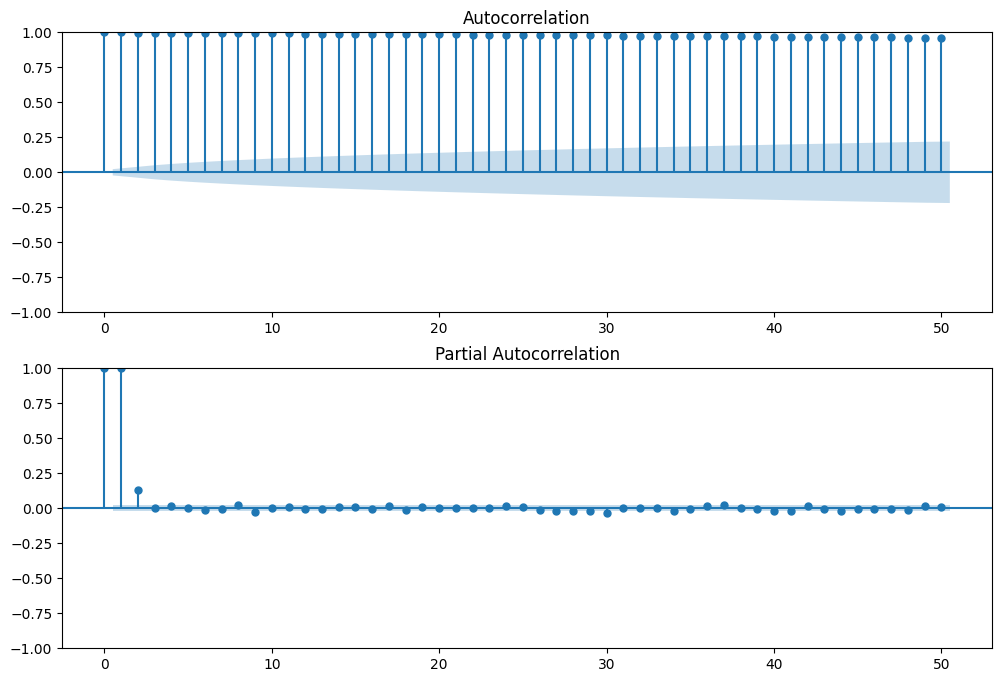

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Ex_rate'], color='blue')
plt.grid(True)
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data['Ex_rate'], lags=50, ax=ax[0])
plot_pacf(data['Ex_rate'], lags=50, ax=ax[1])
plt.show()

In [40]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

c:\Users\revan\Sravani Mam\DSA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Mean Squared Error: 0.042171248182415945


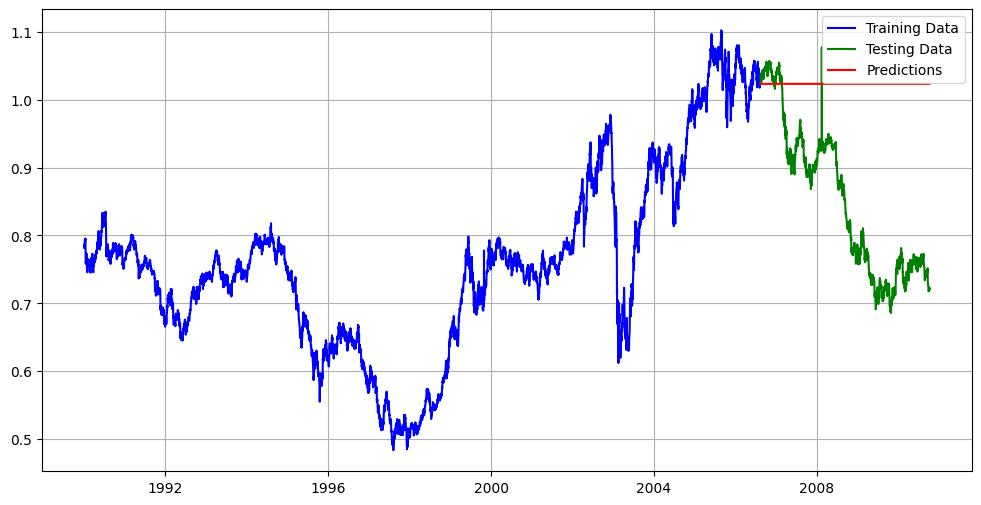

In [41]:
train_size = int(len(data) * 0.8)  
train_data, test_data = data['Ex_rate'][:train_size], data['Ex_rate'][train_size:]
model = SimpleExpSmoothing(train_data)
model_fit = model.fit()
predictions = model_fit.forecast(len(test_data))

mse = mean_squared_error(test_data, predictions)
print('Mean Squared Error:', mse)

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Testing Data', color='green')
plt.plot(test_data.index, predictions, label='Predictions', color='red')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
alpha_values = np.arange(0.1, 1.1, 0.1)  
best_mse = float('inf')
best_params = None

for alpha in alpha_values:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  
        model = SimpleExpSmoothing(train_data)
        try:
            model_fit = model.fit(smoothing_level=alpha, optimized=False)
        except ValueError:
            initial_level = train_data.iloc[0]  
            model_fit = model.fit(smoothing_level=alpha, optimized=False, initial_level=initial_level)

        predictions = model_fit.forecast(len(test_data))
        mse = mean_squared_error(test_data, predictions)
        if mse < best_mse:
            best_mse = mse
            best_params = alpha

best_mse

np.float64(0.04213183157926758)

In [45]:
model_with_trend = Holt(train_data)
model_fit_with_trend = model_with_trend.fit(smoothing_level=0.4, smoothing_trend=0.2, optimized=False)
predictions_with_trend = model_fit_with_trend.forecast(len(test_data))
mse_with_trend = mean_squared_error(test_data, predictions_with_trend)
mse_with_trend

c:\Users\revan\Sravani Mam\DSA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



np.float64(0.02249869721204819)

c:\Users\revan\Sravani Mam\DSA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



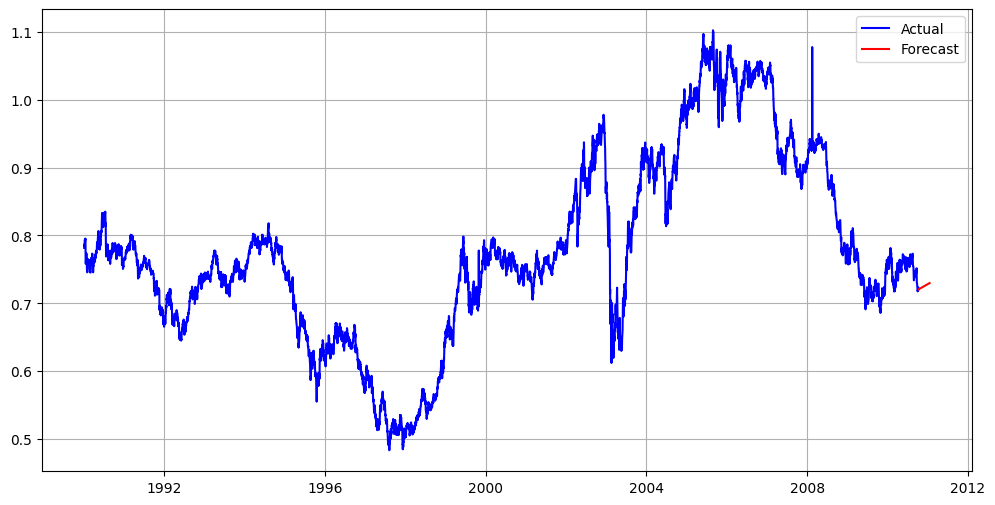

In [46]:
model = Holt(data['Ex_rate'])
model_fit = model.fit(smoothing_level=0.4, smoothing_trend=0.2, optimized=False)
forecast_steps = 100  
forecast_values = model_fit.forecast(steps=forecast_steps)
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Ex_rate'], label='Actual', color='blue')
last_date = data.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='D')[1:]

plt.plot(forecast_dates, forecast_values, label='Forecast', color='red') 
plt.legend()
plt.grid(True)
plt.show()

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [48]:
test_data = test_data.dropna() 
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
test_data_no_zeros = test_data.replace(0, 0.0001)  # Replace with small value to avoid division by zero
mape = np.mean(np.abs((test_data_no_zeros - predictions) / test_data_no_zeros)) * 100
mae

np.float64(22.78995394991468)

In [49]:
rmse

np.float64(0.20536605071712852)

In [50]:
mape

np.float64(22.78995394991468)